In [1]:
# Full implementation of debug-enhanced pipeline with ASCII-only identifiers and labels
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
from datetime import datetime
import yaml
import matplotlib.cm as cm
import __main__ as main

IS_INTERACTIVE = not hasattr(main, '__file__')

# ========== Utility Functions ==========
def clean_label(p):
    return os.path.basename(p).lower().replace("perp", "").replace("par", "").split("slit")[0].strip()

def interactive_plot(fig, title, run_dir=None, save_all=False, image_format='png'):
    fig.suptitle(title)
    plt.show()

    if run_dir:
        save = input(f" Save plot '{title}'? (y/n): ").strip().lower()
        if save == 'y':
            filename = os.path.join(
                run_dir,
                f"{title.replace(' ', '_')}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.{image_format}"
            )
            fig.savefig(filename, format=image_format, bbox_inches='tight')
            print(f" Plot saved to: {filename}")

    proceed = input(" Continue to next step? (y/n): ").strip().lower()
    if proceed != 'y':
        print(" Stopping pipeline by user request.")
        exit()

# ========== GUI Parameter Form ==========
def launch_parameter_form(file_paths):
    root = tk.Tk()
    root.title("Run Parameter Configuration")
    entries = {}

    def add_labeled_entry(parent, label_text, default_value, row):
        label = tk.Label(parent, text=label_text)
        label.grid(row=row, column=0, sticky="e", padx=5, pady=2)
        entry = tk.Entry(parent)
        entry.insert(0, str(default_value))
        entry.grid(row=row, column=1, padx=5, pady=2)
        return entry

    frame = tk.Frame(root, padx=10, pady=10)
    frame.pack()

    tk.Label(frame, text="[ Global Parameters ]", font=('Arial', 10, 'bold')).grid(row=0, columnspan=2, pady=(0, 5))
    entries['background'] = add_labeled_entry(frame, "Background:", 1000.0, 1)
    entries['delta_nm'] = add_labeled_entry(frame, "Emission Slice Width (nm):", 30, 2)
    entries['half_window_pts'] = add_labeled_entry(frame, "Half-Window (rows from center λ₀):", 12, 3)

    entries['save_all'] = tk.IntVar()
    entries['format'] = tk.StringVar(value='png')
    entries['correction_mode'] = tk.StringVar(value='scalar')  # new

    tk.Checkbutton(frame, text="Save all plots automatically", variable=entries['save_all']).grid(row=3, columnspan=2, sticky="w")

    # Plot format
    tk.Label(frame, text="Plot Save Format:").grid(row=4, column=0, sticky="e")
    format_dropdown = tk.OptionMenu(frame, entries['format'], 'png', 'pdf', 'eps', 'svg')
    format_dropdown.grid(row=4, column=1, sticky="w")

    # Correction mode
    tk.Label(frame, text="Correction Mode:").grid(row=5, column=0, sticky="e")
    correction_dropdown = tk.OptionMenu(frame, entries['correction_mode'], 'scalar', 'vector')
    correction_dropdown.grid(row=5, column=1, sticky="w")

    # Lambda_0 values
    tk.Label(frame, text="[ lambda_0 Values Per File ]", font=('Arial', 10, 'bold')).grid(row=6, columnspan=2, pady=(10, 5))
    start_row = 7
    lambda_entries = {}
    for i, f in enumerate(file_paths):
        fname = os.path.basename(f)
        label = tk.Label(frame, text=fname)
        label.grid(row=start_row + i, column=0, sticky="e", padx=5, pady=2)
        default_lambda0 = 550.0 if "dye" in fname.lower() else 583
        entry = tk.Entry(frame)
        entry.insert(0, str(default_lambda0))
        entry.grid(row=start_row + i, column=1, padx=5, pady=2)
        lambda_entries[f] = entry

    def submit():
        values = {
            "background": float(entries['background'].get()),
            "delta_nm": int(entries['delta_nm'].get()),
            "save_all": bool(entries['save_all'].get()),
            "image_format": entries['format'].get(),
            "correction_mode": entries['correction_mode'].get(),
            "lambda_0_dict": {f: float(ent.get()) for f, ent in lambda_entries.items()},
            "half_window_pts": int(entries['half_window_pts'].get()),
        }
        root.destroy()
        root.quit()
        launch_parameter_form.values = values

    submit_btn = tk.Button(frame, text="Submit", command=submit, bg="#4CAF50", fg="white", padx=10)
    submit_btn.grid(row=start_row + len(file_paths) + 1, columnspan=2, pady=(10, 0))

    root.mainloop()
    return launch_parameter_form.values

# ========== Folder Creation ==========
def create_run_folder(base="anisotropy_run"):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    root = tk.Tk()
    root.withdraw()
    base_dir = filedialog.askdirectory(title="Select Base Folder to Save Run")
    if not base_dir:
        base_dir = os.getcwd()
    folder_name = f"{base}_{timestamp}"
    run_dir = os.path.join(base_dir, folder_name)
    os.makedirs(run_dir, exist_ok=True)
    print(f" Run folder created: {run_dir}")
    return run_dir

# ========== Save Config and CSV ==========
def save_run_config(run_dir, config_dict):
    txt_path = os.path.join(run_dir, "run_config.txt")
    yaml_path = os.path.join(run_dir, "run_config.yaml")

    with open(txt_path, "w", encoding='utf-8') as f:
        f.write("=== Anisotropy Run Configuration ===\n")
        f.write(f"Timestamp: {datetime.now()}\n")
        f.write(f"Background: {config_dict['background']}\n")
        f.write(f"Emission Slice Width (nm): {config_dict['delta_nm']}\n")
        f.write(f"Save All Automatically: {config_dict['save_all']}\n")
        f.write(f"Image Format: {config_dict['image_format']}\n")
        f.write("\n--- lambda_0 Values ---\n")
        for fpath, lam in config_dict['lambda_0_dict'].items():
            f.write(f"{os.path.basename(fpath)}: {lam} nm\n")

    with open(yaml_path, "w", encoding='utf-8') as f:
        yaml.dump(config_dict, f, default_flow_style=False, allow_unicode=False)

    print(f" Saved run config to:\n  - {txt_path}\n  - {yaml_path}")

def export_anisotropy_csv(anisotropy_results, run_dir):
    rows = []
    for file, data in anisotropy_results.items():
        delta_E = (1240 / np.array(data["excitation_wavelengths"])) - (1240 / data["lambda_0"])
        for E, r in zip(delta_E, data["anisotropy"]):
            rows.append({
                "Sample": clean_label(file),
                "Delta Excitation Energy (eV)": E,
                "Anisotropy": r
            })

    df_out = pd.DataFrame(rows)
    csv_filename = os.path.join(run_dir, f"anisotropy_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
    df_out.to_csv(csv_filename, index=False)
    print(f" Anisotropy data saved to: {csv_filename}")
    return df_out, csv_filename

# ========== Main Runner ==========
def run_full_anisotropy_pipeline():
    file_paths = filedialog.askopenfilenames(
        title="Select PLE CSV Files",
        filetypes=[("CSV Files", "*.csv")]
    )
    if not file_paths:
        print(" No files selected. Exiting.")
        return

    file_paths = list(file_paths)
    param_data = launch_parameter_form(file_paths)
    run_dir = create_run_folder()

    print(f" Parameters selected:")
    for k, v in param_data.items():
        print(f"   {k}: {v}")

    print(" Starting analysis pipeline...")
    results, _ = revised_pipeline_stepwise_debug(
        file_paths=file_paths,
        lambda_0_dict=param_data["lambda_0_dict"],
        background=param_data["background"],
        delta_nm=param_data["delta_nm"],
        run_dir=run_dir,
        save_all=param_data["save_all"],
        image_format=param_data["image_format"],
        correction_mode=param_data["correction_mode"],
        half_window_pts=param_data["half_window_pts"]
    )

    export = input("Export anisotropy results as CSV? (y/n): ").strip().lower()
    if export == 'y':
        export_anisotropy_csv(results, run_dir)

    save_run_config(run_dir, param_data)
    print(f" Pipeline complete. All outputs saved to: {run_dir}")



In [2]:
# Revised Pipeline with Full Diagnostic Features (ASCII-safe)
def revised_pipeline_stepwise_debug(file_paths, lambda_0_dict, background=1000.0, delta_nm=30,
                                     run_dir=None, save_all=False, image_format='png',
                                     correction_mode="scalar", half_window_pts=12):
    lamp_corrected_dict = {}
    anisotropy_results = {}
    C_scalar_dict = {}
    C_vector_dict = {}

    os.makedirs(os.path.join(run_dir, "plots", "lamp"), exist_ok=True)
    os.makedirs(os.path.join(run_dir, "plots", "slices"), exist_ok=True)
    os.makedirs(os.path.join(run_dir, "plots", "corrected_intensity"), exist_ok=True)
    os.makedirs(os.path.join(run_dir, "plots", "anisotropy"), exist_ok=True)
    os.makedirs(os.path.join(run_dir, "arrays"), exist_ok=True)

    print("\\n[1/4]  Step 1: Lamp Correction and Initial Plots")
    all_lamps = []
    all_raws = []
    all_corrs = []
    labels = []
    color_cycle = iter(cm.tab10.colors)

    for file in file_paths:
        print(f"   - Processing file: {os.path.basename(file)}")
        label = clean_label(file)  # Ensure label is defined here

        df_raw = pd.read_csv(file, header=None)
        # Drop second row (unit labels), reset
        df_cleaned = df_raw.drop(index=1).reset_index(drop=True)

        # Keep the first column as "emission wavelength"
        df_cleaned.columns = [df_raw.iloc[0, 0]] + df_raw.iloc[0, 1:].tolist()

        # Drop first row (header already used), reset
        df_cleaned = df_cleaned.drop(index=0).reset_index(drop=True)

        # Convert everything to numeric, but explicitly extract lambda_em from the first column
        lambda_em_col = pd.to_numeric(df_cleaned.iloc[:, 0], errors='coerce')
        lambda_em = lambda_em_col[lambda_em_col.notna()].values
        if np.any(np.isnan(lambda_em_col.values)):
            print(f"     - Removed {np.isnan(lambda_em_col.values).sum()} NaNs from lambda_em column.")
        lambda_ex = pd.to_numeric(df_cleaned.columns[1:], errors='coerce').values
        
        print(f"     - Lambda_em contains {np.isnan(lambda_em).sum()} NaNs out of {len(lambda_em)} total")


        # Full raw matrix, including NaNs
        M_full = df_cleaned.values
        M = M_full[:-1, 1:]  # Exclude first col (emission λ), exclude lamp row
        M = pd.DataFrame(M).apply(pd.to_numeric, errors='coerce').values
        L = pd.to_numeric(M_full[-1, 1:], errors='coerce')  # Convert to float, set bad values to NaN, Last row (lamp), skip first column
        if np.any(pd.isnull(L)):
            print(f"     - Warning: Lamp vector contains NaNs at indices: {np.where(pd.isnull(L))[0]}")
        L = np.array(L, dtype=float)  # Force final conversion to float array
        print(f"     - Lamp Vector (L) Stats: min={np.nanmin(L):.2f}, max={np.nanmax(L):.2f}, mean={np.nanmean(L):.2f}")
        
        # Save the full raw matrix (with potential NaNs) for inspection
        full_matrix_path = os.path.join(run_dir, "arrays", f"{os.path.basename(file)}_raw_matrix_with_nans.csv")
        df_cleaned.to_csv(full_matrix_path, index=False)
        print(f"     - Full raw matrix with NaNs saved to: {full_matrix_path}")

        #lambda_em = df.iloc[:, 0].astype(float).values
        #lambda_ex = df.columns[1:].astype(float).values
        #M_full = df.values  # Keep full matrix including the NaN in last row, first column
        #M = M_full[:-1, 1:]  # Exclude first column (emission λ), exclude lamp row
        #L = M_full[-1, 1:]   # Last row (lamp), skip first column (NaN)

        # Debug info for lamp vector
        print(f"     - Lamp Vector (L) Stats: min={L.min():.2f}, max={L.max():.2f}, mean={L.mean():.2f}")
        lamp_save_path = os.path.join(run_dir, "arrays", f"{os.path.basename(file)}_lamp_vector.csv")
        np.savetxt(lamp_save_path, L, delimiter=",")
        print(f"     - Lamp vector saved to: {lamp_save_path}")

        lamp_corrected = (M - background) / L[np.newaxis, :]

        lamp_corrected_dict[file] = {
            "corrected": lamp_corrected,
            "lambda_em": lambda_em,
            "lambda_ex": lambda_ex,
            "lamp": L,
            "raw": M
        }

        lambda_0 = lambda_0_dict.get(file, 571.0)
        i_star = np.argmin(np.abs(lambda_em - lambda_0))
        start = max(i_star - half_window_pts, 0)
        end = min(i_star + half_window_pts + 1, len(lambda_em))
        
        print(f"     > Closest emission to lambda_0 = {lambda_0} is {lambda_em[i_star]:.3f} nm at index {i_star}")
        print(f"   > Dye: {label}")
        print(f"     - Lambda_0: {lambda_0} nm")
        print(f"     - Emission slice indices: {start} to {end}")
        print(f"     - Emission wavelengths: {lambda_em[start]:.3f} to {lambda_em[end-1]:.3f}")
        # Save emission slice wavelengths to CSV
        emission_wavelengths = lambda_em[start:end]
        wavelengths_path = os.path.join(run_dir, "arrays", f"{os.path.basename(file)}_emission_slice_wavelengths.csv")
        np.savetxt(wavelengths_path, emission_wavelengths, delimiter=",", header="emission_wavelengths_nm", comments='')
        print(f"     - Emission wavelengths saved to: {wavelengths_path}")
        print(f"     - Lamp function shape: {lamp_corrected_dict[file]['lamp'].shape}")
        print(f"     - Lamp function (first 10 values): {lamp_corrected_dict[file]['lamp'][:10]}")

        M_slice = M[start:end, :]
        avg_emission = np.mean(M_slice, axis=0)
        avg_raw = avg_emission
        avg_corr = (avg_emission - background) / L

        all_lamps.append((lambda_ex, L, os.path.basename(file)))
        all_raws.append(avg_raw)
        all_corrs.append(avg_corr)
        labels.append(os.path.basename(file))

    fig, ax = plt.subplots(figsize=(10, 6))
    for x, y, label in all_lamps:
        ax.plot(x, y, label=label)
    ax.set_xlabel("Excitation Wavelength (nm)")
    ax.set_ylabel("Lamp Intensity")
    ax.legend()
    save = input(" Save this figure? (y/n): ").strip().lower()
    if save == 'y':
        path = os.path.join(run_dir, "plots", "lamp", f"lamp_functions_{label}.{image_format}")
        fig.canvas.draw()
        fig.savefig(path, bbox_inches='tight', format=image_format)
        print(f" Saved to: {path}")
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 6))
    for raw, corr, label in zip(all_raws, all_corrs, labels):
        color = next(color_cycle)
        ax.plot(lambda_ex, raw, linestyle='--', color=color, label=f"{label} Raw")
        ax.plot(lambda_ex, corr, linestyle='-', color=color, label=f"{label} Corrected")
    ax.set_xlabel("Excitation Wavelength (nm)")
    ax.set_ylabel("Signal Intensity")
    ax.legend()
    save = input(" Save this figure? (y/n): ").strip().lower()
    if save == 'y':
        path = os.path.join(run_dir, "plots", "lamp", f"lamp_functions_{label}.{image_format}")
        fig.canvas.draw()
        fig.savefig(path, bbox_inches='tight', format=image_format)
        print(f" Saved to: {path}")
    plt.show()
    
    print(" Generating diagnostic plot (no dye, raw excluded, color by sample)...")

    fig, ax = plt.subplots(figsize=(10, 6))
    color_cycle = iter(cm.tab10.colors)
    sample_colors = {}  # Map from label -> color

    # Group files by label (excluding dye)
    samples = {}
    for file in file_paths:
        if "dye" in file.lower():
            continue
        label = clean_label(file)
        samples.setdefault(label, []).append(file)

    for label, group in samples.items():
        color = next(color_cycle)
        sample_colors[label] = color

        for file in group:
            data = lamp_corrected_dict[file]
            lambda_ex = data["lambda_ex"]
            corrected = data["corrected"]
            avg_corr = np.mean(corrected, axis=0)

            if "perp" in file.lower():
                ax.plot(lambda_ex, avg_corr, linestyle='--', color=color, label=f"{label} Perp")
            elif "par" in file.lower():
                ax.plot(lambda_ex, avg_corr, linestyle='-', color=color, label=f"{label} Par")

    ax.set_xlabel("Excitation Wavelength (nm)")
    ax.set_ylabel("Lamp Corrected Intensity")
    ax.set_title("Corrected Intensities (Samples Only)")
    ax.legend()
    ax.grid(True)
    save = input(" Save this plot? (y/n): ").strip().lower()
    if save == 'y':
        path = os.path.join(run_dir, "plots", "lamp", f"sample_corrected_only.{image_format}")
        fig.canvas.draw()
        fig.savefig(path, bbox_inches='tight', format=image_format)
        print(f" Saved to: {path}")
    plt.show()
    
    proceed = input(" Proceed to Step 2? (y/n): ").strip().lower()
    if proceed != 'y':
        print(" Exiting pipeline at user request after Step 1.")
        return None, lamp_corrected_dict

    print("\n[2/4]  Step 2: Scalar or Vector Correction using Dye")
    for file in file_paths:
        if "dye" not in file.lower() or "perp" not in file.lower():
            continue

        label = clean_label(file)
        lambda_0 = lambda_0_dict[file]
        lambda_em = lamp_corrected_dict[file]["lambda_em"]
        lambda_ex = lamp_corrected_dict[file]["lambda_ex"]
        dye_perp = lamp_corrected_dict[file]["raw"]
        lamp = lamp_corrected_dict[file]["lamp"]

        matching_par = [p for p in file_paths if clean_label(p) == label and "par" in p.lower()]
        if not matching_par:
            print(f" No matching parallel file found for {label}")
            continue
        matching_par = matching_par[0]
        dye_par = lamp_corrected_dict[matching_par]["raw"]

        i_star = np.argmin(np.abs(lambda_em - lambda_0))
        print(f"\n----- Slice Diagnostic for {label} -----")
        print(f"Lambda_0 (target emission): {lambda_0:.2f} nm")
        print(f"Closest λ_em: {lambda_em[i_star]:.2f} nm at index {i_star}")
        print(f"Slice indices: {start} to {end - 1}")
        print(f"Slice range: {lambda_em[start]:.2f} nm to {lambda_em[end - 1]:.2f} nm")
        print(f"Total slice width: {lambda_em[end - 1] - lambda_em[start]:.2f} nm")
        print("----------------------------------------\n")
        start = max(i_star - half_window_pts, 0)
        end = min(i_star + half_window_pts + 1, len(lambda_em))
        print(f"     > Closest emission to lambda_0 = {lambda_0} is {lambda_em[i_star]:.3f} nm at index {i_star}")

        M_perp = dye_perp[start:end, :]
        M_par = dye_par[start:end, :]

        with np.errstate(divide='ignore', invalid='ignore'):
            corrected_perp = (M_perp - background) / lamp[np.newaxis, :]
            corrected_par  = (M_par  - background) / lamp[np.newaxis, :]

        I_perp_avg = np.mean(corrected_perp, axis=0)
        I_par_avg = np.mean(corrected_par, axis=0)

        with np.errstate(divide='ignore', invalid='ignore'):
            C_vector = I_par_avg / I_perp_avg

        if correction_mode == "scalar":
            C_scalar = np.nanmean(C_vector)
            I_perp_corr = C_scalar * I_perp_avg
            correction_used = np.full_like(I_perp_avg, C_scalar)
            for j, lam_ex in enumerate(lambda_ex):
                C_scalar_dict[(lam_ex, label)] = correction_used[j]
            print(f"   - C_scalar for {label} = {C_scalar:.4f} (slice width = {end-start})")
            print(f"     - First 10 C_scalar values: {correction_used[:10]}")

        elif correction_mode == "vector":
            C_vector = np.where(np.isfinite(C_vector), C_vector, 1.0)
            I_perp_corr = C_vector * I_perp_avg
            correction_used = C_vector
            C_vector_dict[label] = C_vector
            print(f"   - Vector correction applied for {label} (slice width = {end-start})")
            print(f"     - First 10 C_vector values: {C_vector[:10]}")
        else:
            raise ValueError(f"Unknown correction_mode: {correction_mode}")

        # Check for NaNs or infs
        if np.any(~np.isfinite(correction_used)):
            print(f"     - Warning: Non-finite correction factor(s) in {label}")
        
        
        # === Export raw dye slice matrices for inspection ===
        par_export_path = os.path.join(run_dir, "arrays", f"{label}_dye_parallel_matrix.csv")
        perp_export_path = os.path.join(run_dir, "arrays", f"{label}_dye_perpendicular_matrix.csv")

        # Build DataFrames: rows = emission slice λ, columns = excitation λ
        emission_slice = lambda_em[start:end]
        df_par = pd.DataFrame(M_par, index=np.round(emission_slice, 3), columns=np.round(lambda_ex, 3))
        df_perp = pd.DataFrame(M_perp, index=np.round(emission_slice, 3), columns=np.round(lambda_ex, 3))

        # Label rows
        df_par.index.name = "emission_lambda_nm"
        df_perp.index.name = "emission_lambda_nm"

        df_par.to_csv(par_export_path)
        df_perp.to_csv(perp_export_path)

        print(f"   - Exported parallel matrix to: {par_export_path}")
        print(f"   - Exported perpendicular matrix to: {perp_export_path}")
        
        # Print I_par/I_perp comparison summary
        print(f"     - Mean I_par: {np.mean(I_par_avg):.3f}")
        print(f"     - Mean I_perp_corr: {np.mean(I_perp_corr):.3f}")
        print(f"     - Ratio I_par / I_perp_corr (mean): {np.mean(I_par_avg) / np.mean(I_perp_corr):.3f}")

        # Save correction factor plot
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(lambda_ex, correction_used, label=f"{label} Correction Factor")
        ax.set_xlabel("Excitation Wavelength (nm)")
        ax.set_ylabel("Correction Factor")
        ax.set_title(f"Correction Factor — {label}")
        ax.legend()
        ax.grid(True)
        save = input(" Save correction factor plot? (y/n): ").strip().lower()
        if save == 'y':
            path = os.path.join(run_dir, "plots", "lamp", f"correction_factor_{label}.{image_format}")
            fig.canvas.draw()
            fig.savefig(path, bbox_inches='tight', format=image_format)
            print(f" Saved to: {path}")
        plt.show()

        # Save numeric correction vector
        corr_factor_save_path = os.path.join(run_dir, "arrays", f"{label}_correction_factors.csv")
        np.savetxt(corr_factor_save_path,
                   np.column_stack([lambda_ex, correction_used]),
                   delimiter=",",
                   header="lambda_ex,correction_factor",
                   comments='')
        print(f"     - Saved correction factors to: {corr_factor_save_path}")

        # Save combined values
        np.savetxt(os.path.join(run_dir, "arrays", f"{label}_scalar_correction.csv"),
            np.column_stack([lambda_ex, I_par_avg, I_perp_avg, I_perp_corr, correction_used]),
            delimiter=",",
            header="lambda_ex,I_par_avg,I_perp_avg,I_perp_corr,correction_applied",
            comments='')

        # Summary plot
        fig, ax = plt.subplots(figsize=(8, 5))
        color_par = next(color_cycle)
        color_perp = next(color_cycle)
        ax.plot(lambda_ex, I_par_avg, linestyle='--', color=color_par, label='Parallel Avg (Before)')
        ax.plot(lambda_ex, I_perp_avg, linestyle='--', color=color_perp, label='Perpendicular Avg (Before)')
        ax.plot(lambda_ex, I_par_avg, linestyle='-', color=color_par, label='Parallel Avg (Corrected)')
        ax.plot(lambda_ex, I_perp_corr, linestyle='-', color=color_perp, label='Perpendicular Avg (Corrected)')
        ax.set_title(f"Emission Slices Avg - {label}")
        ax.set_xlabel("Excitation Wavelength (nm)")
        ax.set_ylabel("Lamp Corrected Intensity")
        ax.legend()
        ax.grid(True)
        save = input(" Save this figure? (y/n): ").strip().lower()
        if save == 'y':
            path = os.path.join(run_dir, "plots", "lamp", f"scalar_slices_{label}.{image_format}")
            fig.canvas.draw()
            fig.savefig(path, bbox_inches='tight', format=image_format)
            print(f" Saved to: {path}")
        plt.show()
        
        proceed = input(" Proceed to Step 3? (y/n): ").strip().lower()
        if proceed != 'y':
            print(" Exiting pipeline at user request after Step 2.")
            return None, lamp_corrected_dict

    print("\\n[3/4]  Step 3: Anisotropy Calculation")
    grouped_par, grouped_perp, grouped_labels = [], [], []
    anisotropy_all = {}
    color_cycle = iter(cm.tab10.colors)

    for file in file_paths:
        if "perp" not in file.lower() or "dye" in file.lower():
            continue

        label = clean_label(file)
        lambda_0 = lambda_0_dict[file]
        lambda_em = lamp_corrected_dict[file]["lambda_em"]
        lambda_ex = lamp_corrected_dict[file]["lambda_ex"]
        raw_perp = lamp_corrected_dict[file]["raw"]
        lamp = lamp_corrected_dict[file]["lamp"]

        matching_par = [p for p in file_paths if clean_label(p) == label and "par" in p.lower()]
        if not matching_par:
            print(f" No matching parallel file for {label}")
            continue
        matching_par = matching_par[0]
        raw_par = lamp_corrected_dict[matching_par]["raw"]

        i_star = np.argmin(np.abs(lambda_em - lambda_0))
        print(f"\n----- Slice Diagnostic for {label} -----")
        print(f"Lambda_0 (target emission): {lambda_0:.2f} nm")
        print(f"Closest λ_em: {lambda_em[i_star]:.2f} nm at index {i_star}")
        print(f"Slice indices: {start} to {end - 1}")
        print(f"Slice range: {lambda_em[start]:.2f} nm to {lambda_em[end - 1]:.2f} nm")
        print(f"Total slice width: {lambda_em[end - 1] - lambda_em[start]:.2f} nm")
        print("----------------------------------------\n")
        start = max(i_star - half_window_pts, 0)
        end = min(i_star + half_window_pts + 1, len(lambda_em))
        print(f"     > Closest emission to lambda_0 = {lambda_0} is {lambda_em[i_star]:.3f} nm at index {i_star}")


        M_perp = raw_perp[start:end, :]
        M_par = raw_par[start:end, :]

        with np.errstate(divide='ignore', invalid='ignore'):
            corrected_perp = (M_perp - background) / lamp[np.newaxis, :]
            corrected_par  = (M_par  - background) / lamp[np.newaxis, :]

        I_perp_avg = np.mean(corrected_perp, axis=0)
        I_par_avg = np.mean(corrected_par, axis=0)

        # Save corrected_perp to file
        corrected_perp_path = os.path.join(run_dir, "arrays", f"{label}_corrected_perp.csv")
        np.savetxt(corrected_perp_path,
                   np.column_stack([lambda_ex, I_perp_avg]),
                   delimiter=",",
                   header="lambda_ex,corrected_perp",
                   comments='')
        print(f"   - Saved corrected perpendicular intensities to: {corrected_perp_path}")

        I_corr_perp = []
        r_dict = {}
        for j, lam_ex in enumerate(lambda_ex):
            if correction_mode == "vector":
                C = C_vector_dict.get(label, np.ones_like(lambda_ex))[j]
            else:
                C = C_scalar_dict.get((lam_ex, label), 1.0)

            I_corr_par = I_par_avg[j]
            corrected_perp_val = C * I_perp_avg[j]
            r = (I_corr_par - corrected_perp_val) / (I_corr_par + 2 * corrected_perp_val)
            r_dict[lam_ex] = r
            I_corr_perp.append(corrected_perp_val)

        grouped_par.append(I_par_avg)
        grouped_perp.append(I_corr_perp)
        grouped_labels.append(label)

        delta_E = (1240 / lambda_ex) - (1240 / lambda_0)
        anisotropy_all[label] = (delta_E, list(r_dict.values()))

        np.savetxt(
            os.path.join(run_dir, "arrays", f"{label}_anisotropy.csv"),
            np.column_stack([lambda_ex, np.array(list(r_dict.values()))]),
            delimiter=",",
            header="lambda_ex,anisotropy",
            comments=''
        )

        anisotropy_results[file] = {
            "anisotropy": list(r_dict.values()),
            "excitation_wavelengths": list(r_dict.keys()),
            "lambda_0": lambda_0
        }
        
    # Export all intensities Step 3 to a single CSV for cross check
    intensity_export_path = os.path.join(run_dir, "arrays", "step3_corrected_intensity_comparison.csv")
    export_df = pd.DataFrame({"lambda_ex": lambda_ex})

    for par_vals, perp_vals, label in zip(grouped_par, grouped_perp, grouped_labels):
        export_df[f"{label}_parallel"] = par_vals
        export_df[f"{label}_perp_corrected"] = perp_vals

    export_df.to_csv(intensity_export_path, index=False)
    print(f"   - Exported all Step 3 parallel and corrected ⊥ intensities to: {intensity_export_path}")

    fig, ax = plt.subplots(figsize=(10, 6))
    for I_par, I_corr_perp, label in zip(grouped_par, grouped_perp, grouped_labels):
        color = next(color_cycle)
        ax.plot(lambda_ex, I_par, linestyle='-', color=color, label=f"{label} ‖")
        ax.plot(lambda_ex, I_corr_perp, linestyle='--', color=color, label=f"{label} ⊥ corrected")
    ax.set_xlabel("Excitation λ (nm)")
    ax.set_ylabel("Lamp + Scalar Corrected Intensity")
    ax.legend()
    save = input(" Save this figure? (y/n): ").strip().lower()
    if save == 'y':
        path = os.path.join(run_dir, "plots", "lamp", f"lamp_functions_{label}.{image_format}")
        fig.canvas.draw()  # Ensure plot is rendered before saving
        fig.savefig(path, bbox_inches='tight', format=image_format)
        print(f" Saved to: {path}")
    plt.show()

    #fig, ax = plt.subplots(figsize=(10, 6))
    #for I_par, I_corr_perp, label in zip(grouped_par, grouped_perp, grouped_labels):
        #color = next(color_cycle)
        #ax.plot(lambda_ex, I_par, linestyle='-', color=color, label=f"{label} ‖")
        #ax.plot(lambda_ex, I_corr_perp, linestyle='--', color=color, label=f"{label} ⊥ corrected")
    #ax.set_xlabel("Excitation λ (nm)")
    #ax.set_ylabel("Lamp + Scalar Corrected Intensity")
    #ax.legend()
    #interactive_plot(fig, "Corrected Intensities — All Samples", run_dir, save_all, image_format)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    for label, (ΔE, r_vals) in anisotropy_all.items():
        ax.plot(ΔE, r_vals, label=label)
    ax.set_xlabel("Relative Excitation Energy (eV)")
    ax.set_ylabel("Anisotropy")
    ax.grid(True)
    ax.legend()
    save = input(" Save this figure? (y/n): ").strip().lower()
    if save == 'y':
        path = os.path.join(run_dir, "plots", "lamp", f"lamp_functions_{label}.{image_format}")
        fig.canvas.draw()  # Ensure plot is rendered before saving
        fig.savefig(path, bbox_inches='tight', format=image_format)
        print(f" Saved to: {path}")
    plt.show()

    #fig, ax = plt.subplots(figsize=(10, 6))
    #for label, (ΔE, r_vals) in anisotropy_all.items():
    #    ax.plot(ΔE, r_vals, label=label)
    #ax.set_xlabel("Relative Excitation Energy (eV)")
    #ax.set_ylabel("Anisotropy")
    #ax.grid(True)
    #ax.legend()
    #interactive_plot(fig, "Anisotropy vs ΔE — All Samples", run_dir, save_all, image_format)

    # Individual anisotropy plots (smooth line)
    for label, (ΔE, r_vals) in anisotropy_all.items():
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(ΔE, r_vals, linestyle='-', label=f"Anisotropy — {label}")
        ax.set_xlabel("Relative Excitation Energy (eV)")
        ax.set_ylabel("Anisotropy")
        ax.grid(True)
        ax.legend()
        save = input(" Save this figure? (y/n): ").strip().lower()
        if save == 'y':
            path = os.path.join(run_dir, "plots", "lamp", f"lamp_functions_{label}.{image_format}")
            fig.canvas.draw()  # Ensure plot is rendered before saving
            fig.savefig(path, bbox_inches='tight', format=image_format)
            print(f" Saved to: {path}")
        plt.show()
    #for label, (ΔE, r_vals) in anisotropy_all.items():
    #    fig, ax = plt.subplots(figsize=(8, 5))
    #    ax.plot(ΔE, r_vals, linestyle='-', label=f"Anisotropy — {label}")
    #    ax.set_xlabel("Relative Excitation Energy (eV)")
    #    ax.set_ylabel("Anisotropy")
    #    ax.grid(True)
    #    ax.legend()
    #    interactive_plot(fig, f"Anisotropy — {label}", run_dir, save_all, image_format)
    proceed = input(" Proceed to Step 4? (y/n): ").strip().lower()
    if proceed != 'y':
        print(" Exiting pipeline at user request after Step 3.")
        return None, lamp_corrected_dict

    print("\n[4/4]  Completed all files.")
    return anisotropy_results, lamp_corrected_dict


 Run folder created: C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_20250723_153332
 Parameters selected:
   background: 1000.0
   delta_nm: 30
   save_all: False
   image_format: png
   correction_mode: scalar
   lambda_0_dict: {'C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025/par_dye.csv': 550.0, 'C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025/perp_dye.csv': 550.0, 'C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025/Zb571_CHCl3_par.csv': 583.0, 'C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025/Zb571_CHCl3_perp.csv': 583.0}
   half_window_pts: 12
 Starting analysis pipeline...
\n[1/4]  Step 1: Lamp Correction and Initial Plots
   - Processing file: par_dye.csv
     - Removed 1 NaNs from lambda_em column.
     - Lambda_em contains 0 NaNs out of 1024 total
     - Lamp Vector (L) Stats: min=0.02, max=0.06, mean=0.04
     - Full raw matrix with NaNs saved to: C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_2

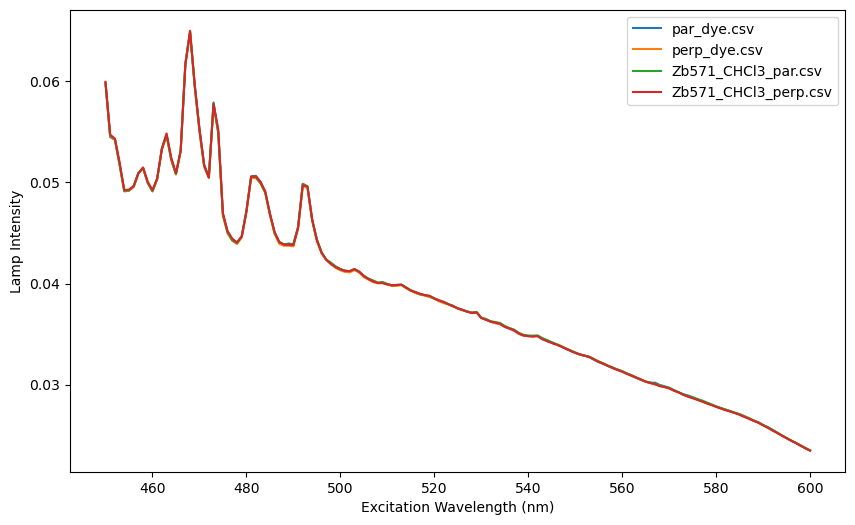

 Saved to: C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_20250723_153332\plots\lamp\lamp_functions_Zb571_CHCl3_perp.csv.png


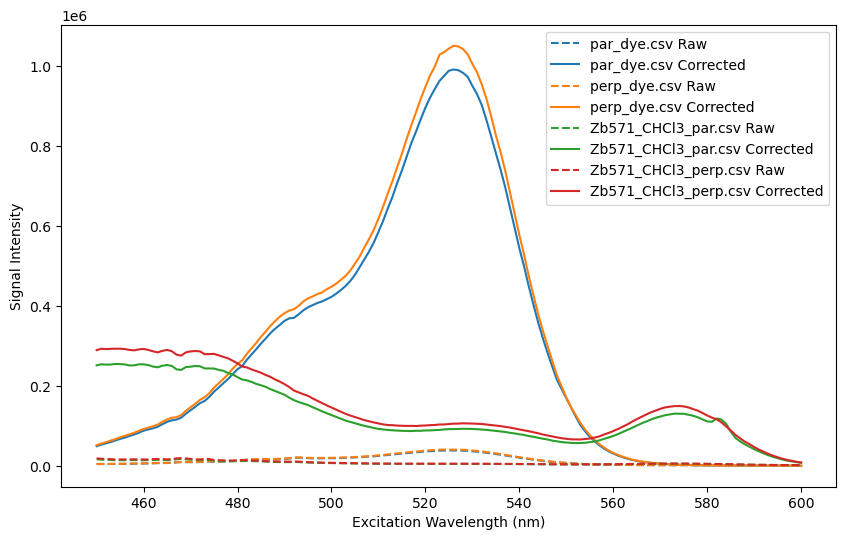

 Generating diagnostic plot (no dye, raw excluded, color by sample)...
 Saved to: C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_20250723_153332\plots\lamp\sample_corrected_only.png


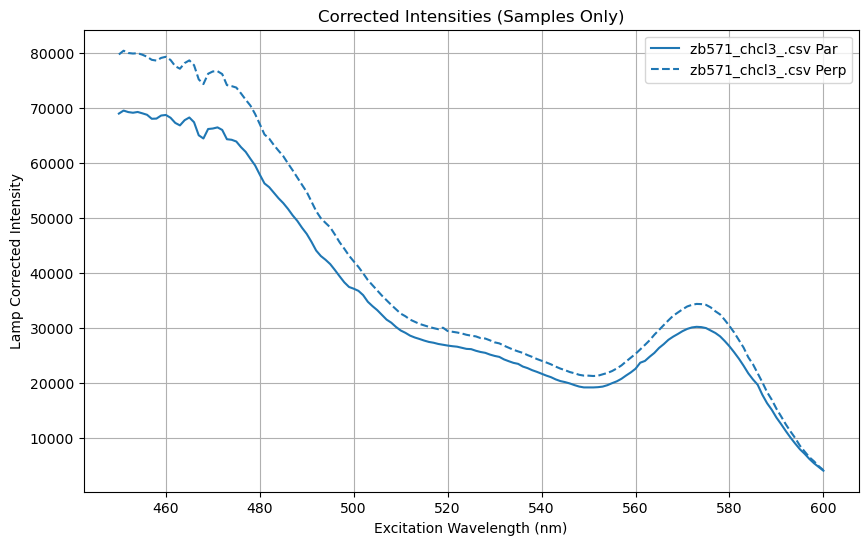

C:\Users\wesle\AppData\Local\Temp\ipykernel_10244\2686461731.py:287: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()



[2/4]  Step 2: Scalar or Vector Correction using Dye

----- Slice Diagnostic for _dye.csv -----
Lambda_0 (target emission): 550.00 nm
Closest λ_em: 549.96 nm at index 394
Slice indices: 642 to 666
Slice range: 581.48 nm to 584.52 nm
Total slice width: 3.04 nm
----------------------------------------

     > Closest emission to lambda_0 = 550.0 is 549.957 nm at index 394
   - C_scalar for _dye.csv = 0.9473 (slice width = 25)
     - First 10 C_scalar values: [0.94732327 0.94732327 0.94732327 0.94732327 0.94732327 0.94732327
 0.94732327 0.94732327 0.94732327 0.94732327]
   - Exported parallel matrix to: C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_20250723_153332\arrays\_dye.csv_dye_parallel_matrix.csv
   - Exported perpendicular matrix to: C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_20250723_153332\arrays\_dye.csv_dye_perpendicular_matrix.csv
     - Mean I_par: 295192.687
     - Mean I_perp_corr: 295411.238
     - Ratio I_par / I_pe

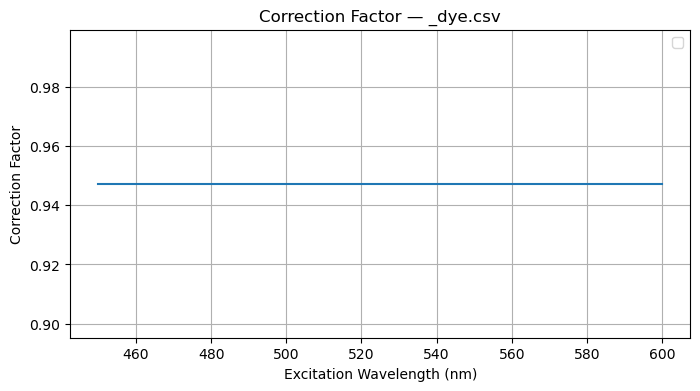

     - Saved correction factors to: C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_20250723_153332\arrays\_dye.csv_correction_factors.csv
 Saved to: C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_20250723_153332\plots\lamp\scalar_slices__dye.csv.png


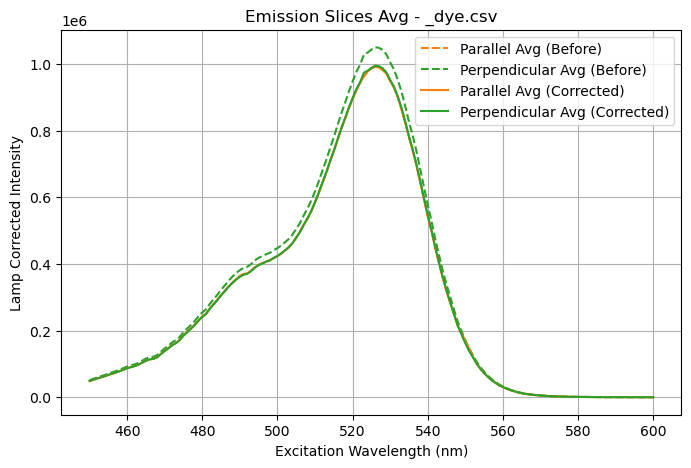

\n[3/4]  Step 3: Anisotropy Calculation

----- Slice Diagnostic for zb571_chcl3_.csv -----
Lambda_0 (target emission): 583.00 nm
Closest λ_em: 583.00 nm at index 654
Slice indices: 382 to 406
Slice range: 548.42 nm to 551.49 nm
Total slice width: 3.06 nm
----------------------------------------

     > Closest emission to lambda_0 = 583.0 is 583.000 nm at index 654
   - Saved corrected perpendicular intensities to: C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_20250723_153332\arrays\zb571_chcl3_.csv_corrected_perp.csv
   - Exported all Step 3 parallel and corrected ⊥ intensities to: C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_20250723_153332\arrays\step3_corrected_intensity_comparison.csv
 Saved to: C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_20250723_153332\plots\lamp\lamp_functions_zb571_chcl3_.csv.png


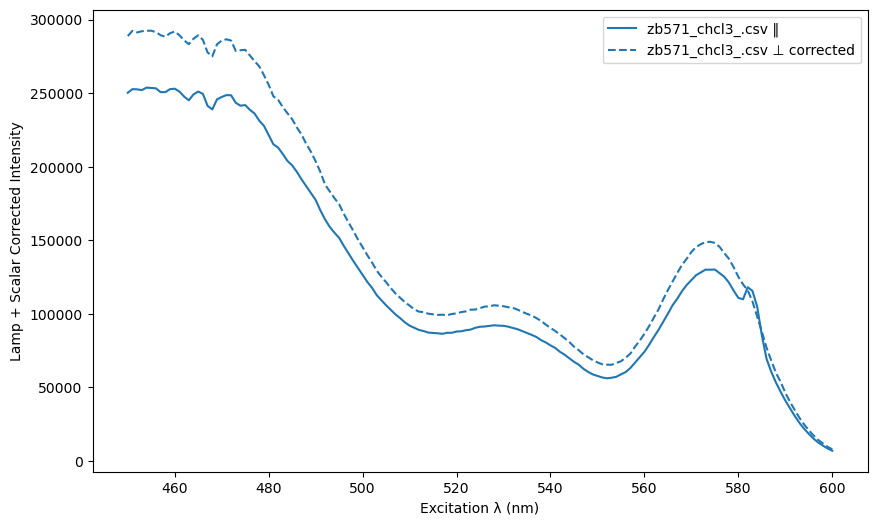

 Saved to: C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_20250723_153332\plots\lamp\lamp_functions_zb571_chcl3_.csv.png


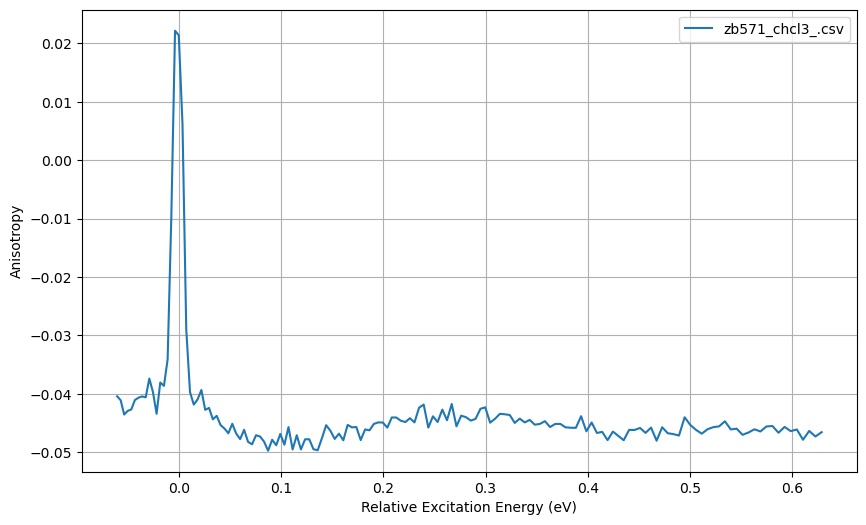

 Saved to: C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_20250723_153332\plots\lamp\lamp_functions_zb571_chcl3_.csv.png


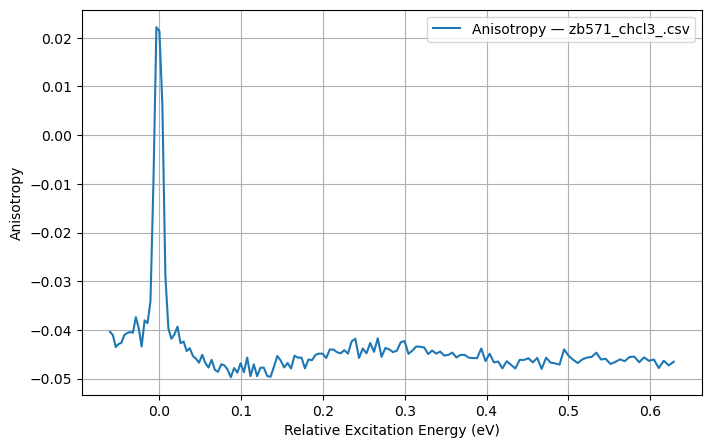


[4/4]  Completed all files.
 Anisotropy data saved to: C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_20250723_153332\anisotropy_results_20250723_153348.csv
 Saved run config to:
  - C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_20250723_153332\run_config.txt
  - C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_20250723_153332\run_config.yaml
 Pipeline complete. All outputs saved to: C:/Users/wesle/Downloads/Fernanda_PLE treatment/May_2025\anisotropy_run_20250723_153332


In [8]:
run_full_anisotropy_pipeline()